# Sales Prediction

Using machine learning to help organization prepare to handle dynamic market demand. Organization may infer the prediction to establish rule, plan, or strategy to further strengthen market position.

## Library Import and Configuration

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer

from util.dbconn import DbConn

In [2]:
WAREHOUSE_CONN = {
    'user': 'postgres',
    'password': 'qshOke46RvOg0',
    'host': '10.182.0.3',
    'port': '8084',
    'dbname': 'postgres'
}

In [3]:
postgres_conn = DbConn(WAREHOUSE_CONN).get_conn()

## Data Overview

In [4]:
sql = """SELECT 
	dd."year",
	dd."month",
	dd.week_num_in_year,
	dd."date",
	count(DISTINCT fo.order_legacy_id) as count_order
FROM 
	warehouse.fact_order fo
LEFT JOIN warehouse.date_dim dd ON
	fo.order_date = dd.date_id
GROUP BY 1,2,3,4;
"""

In [5]:
df = pd.read_sql(sql=sql, con=postgres_conn)

display(df.info())
display(df.describe())
display(df.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   year              634 non-null    int64
 1   month             634 non-null    int64
 2   week_num_in_year  634 non-null    int64
 3   date              634 non-null    int64
 4   count_order       634 non-null    int64
dtypes: int64(5)
memory usage: 24.9 KB


None

,year,month,week_num_in_year,date,count_order
count,634.000000,634.000000,634.000000,634.000000,634.000000
mean,2017.383281,5.938486,24.501577,15.597792,156.847003
std,0.533051,3.214452,14.111411,8.768610,94.224817
min,2016.000000,1.000000,1.000000,1.000000,1.000000
25%,2017.000000,3.000000,13.000000,8.000000,96.000000
50%,2017.000000,6.000000,24.000000,15.500000,148.000000
75%,2018.000000,8.000000,35.000000,23.000000,215.750000
max,2018.000000,12.000000,53.000000,31.000000,1176.000000


,year,month,week_num_in_year,date,count_order
0,2016,9,36,4,1
1,2016,9,37,5,1
2,2016,9,38,13,1
3,2016,9,38,15,1
4,2016,10,40,2,1


### Check Null Values

In [6]:
df.isnull().sum()

year                0
month               0
week_num_in_year    0
date                0
count_order         0
dtype: int64

## Exploratory Data Analysis

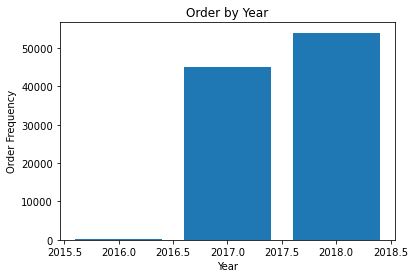

,year,count_order
0,2016,329
1,2017,45101
2,2018,54011


In [7]:
fig, ax = plt.subplots()

_df_temp = df.loc[:, ['year', 'count_order']].groupby('year', as_index=False).sum()

ax.bar(_df_temp['year'], _df_temp['count_order'])
ax.set_title('Order by Year')
ax.set_xlabel('Year')
ax.set_ylabel('Order Frequency')

plt.show()
display(_df_temp.head(15))

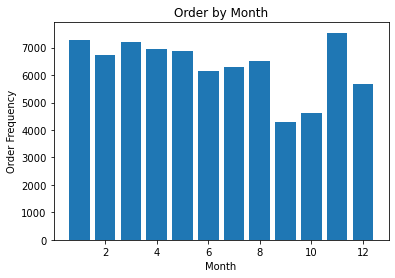

,year,month,count_order
0,2016,9,4
1,2016,10,324
2,2016,12,1
3,2017,1,800
4,2017,2,1780
5,2017,3,2682
6,2017,4,2404
7,2017,5,3700
8,2017,6,3245
9,2017,7,4026


In [8]:
fig, ax = plt.subplots()

_df_temp = df.loc[:, ['year', 'month', 'count_order']] \
            .groupby(by=['year', 'month'], as_index=False) \
            .sum()

ax.bar(_df_temp['month'], _df_temp['count_order'])
ax.set_title('Order by Month')
ax.set_xlabel('Month')
ax.set_ylabel('Order Frequency')

plt.show()
display(_df_temp.head(15))

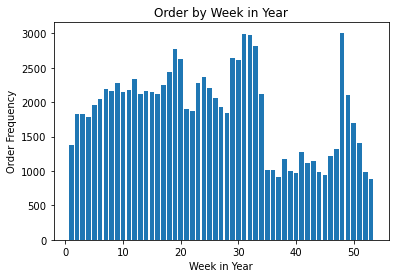

,week_num_in_year,count_order
0,1,1383
1,2,1831
2,3,1830
3,4,1788
4,5,1952
5,6,2051
6,7,2188
7,8,2167
8,9,2282
9,10,2140


In [9]:
fig, ax = plt.subplots()

_df_temp = df.loc[:, ['week_num_in_year', 'count_order']] \
            .groupby(by='week_num_in_year', as_index=False) \
            .sum()

ax.bar(_df_temp['week_num_in_year'], _df_temp['count_order'])
ax.set_title('Order by Week in Year')
ax.set_xlabel('Week in Year')
ax.set_ylabel('Order Frequency')

plt.show()
display(_df_temp.head(15))

In [10]:
model_df = df.copy()

## Data Preprocessing

In [11]:
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
normalizer = Normalizer(norm='l2')
standardize = StandardScaler()

## Utility Functions

In [33]:
def _tscv(X, pipe):
    tscv = TimeSeriesSplit()

    errors = []

    for train_index, test_index in tscv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        mse = mean_squared_error(y_test, y_pred, squared=False)
        errors.append(mse)
    
    print(errors)
    print(sum(errors)/len(errors))

In [13]:
def shift(data, n_in=1, n_out=1, dropna=True):
    """
    Arguments:
        data: Sequence of observations as DataFrame or Numpy Array.
        n_in: Number of lag observations as input.
        n_out: Number of observations as output.
        dropna: Boolean whether to drop rows with NaN values.
    Returns:
        df: Pandas DataFrame
    """
    
    try:
        var = range(0, data.shape[1]) if isinstance(data, np.ndarray) else \
                data.columns if isinstance(data, pd.DataFrame) else None
    except IndexError as e:
        var = range(0, 1)
    
    if var is None:
        raise Exception('Expected pandas.DataFrame or numpy.ndarray got {}'.format(type(data)))
    
    df = pd.DataFrame(data)
    cols, names = [], []
    
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('{n}(t-{i})'.format(n=v, i=i)) for v in var]
    
    for i in range(0, n_out):
        cols.append(df.shift(i))
        if i == 0:
            names += [('{n}(t)'.format(n=v)) for v in var]
        else:
            names += [('{n}(t+{i})'.format(n=v, i=i)) for v in var]
    
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    if dropna:
        agg.dropna(inplace=True)
    
    return agg

In [14]:
def evaluate(y_actual, y_pred):
    med_ae = median_absolute_error(y_actual, y_pred)
    mae = mean_absolute_error(y_actual, y_pred)
    mse = mean_squared_error(y_actual, y_pred)
    rmse = mean_squared_error(y_actual, y_pred, squared=False)
    
    return {
        'Median Absolute Error': med_ae,
        'Mean Absolute Error': mae,
        'Mean Squared Error': mse,
        'Root Mean Squared Error': rmse
    }

In [15]:
def _tscv_eval(X, pipe):
    tscv = TimeSeriesSplit()

    errors = []

    for train_index, test_index in tscv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        error = evaluate(y_test, y_pred)
        errors.append(error)
    
    print(json.dumps(errors, indent=4))

## Naive Model

In [16]:
from sklearn.metrics import median_absolute_error, mean_absolute_error, mean_squared_error

In [17]:
y = model_df.loc[:, 'count_order']
# Set to predict the mean
y_pred = [y.mean() for i in range(0, len(y))]

mse = mean_squared_error(y, y_pred)
print(mse)

8864.3125541104


In [18]:
y = model_df.loc[:, 'count_order']
# Set to predict the mean
y_pred = [y.mean() for i in range(0, len(y))]

print(json.dumps(evaluate(y, y_pred), indent=4))

{
    "Median Absolute Error": 59.84700315457414,
    "Mean Absolute Error": 70.68741354775149,
    "Mean Squared Error": 8864.3125541104,
    "Root Mean Squared Error": 94.15047824684908
}


## MLP Regressor

In [19]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import TimeSeriesSplit

In [20]:
X = model_df.loc[:, ['year', 'month', 'week_num_in_year', 'date']].to_numpy()
y = model_df.loc[:, 'count_order'].to_numpy()

### Hyperparameter Tuning

In [21]:
rmse_scorer = make_scorer(mean_squared_error, squared=False)

pipe = Pipeline([
        ('scale', StandardScaler()),
        ('mlp', MLPRegressor(max_iter=10000))])

param_grid = dict(mlp__hidden_layer_sizes=[(100,30),(100,30,10)],
                  mlp__activation=['relu', 'logistic'],
                  mlp__solver=['lbfgs', 'adam'],
                  mlp__tol=[0.005, 0.01, 0.05, 0.1],
                  mlp__learning_rate_init=[0.005,0.01,0.05,0.1,0.5])

grid = GridSearchCV(pipe, param_grid=param_grid, cv=TimeSeriesSplit(n_splits=2),
                    scoring=rmse_scorer, n_jobs=1, verbose=1)
grid.fit(X, y)

Fitting 2 folds for each of 240 candidates, totalling 480 fits


/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=None),
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('mlp', MLPRegressor(max_iter=10000))]),
             n_jobs=1,
             param_grid={'mlp__activation': ['identity', 'relu', 'logistic'],
                         'mlp__hidden_layer_sizes': [(100, 30), (100, 30, 10)],
                         'mlp__learning_rate_init': [0.005, 0.01, 0.05, 0.1,
                                                     0.5],
                         'mlp__solver': ['lbfgs', 'adam'],
                         'mlp__tol': [0.005, 0.01, 0.05, 0.1]},
             scoring=make_scorer(mean_squared_error, squared=False), verbose=1)

In [22]:
print(grid.best_score_)
print(grid.best_estimator_)

2801.217214936273
Pipeline(steps=[('scale', StandardScaler()),
                ('mlp',
                 MLPRegressor(hidden_layer_sizes=(100, 30, 10),
                              learning_rate_init=0.5, max_iter=10000,
                              solver='lbfgs', tol=0.1))])


In [ ]:
## DO NOT DELETE
# mlpr = MLPRegressor(
#             hidden_layer_sizes=(100,30),
#             activation='relu',
#             solver='lbfgs',
#             learning_rate='constant',
#             learning_rate_init=0.001,
#             max_iter=1000)

### Default Parameter

In [25]:
mlpr = MLPRegressor(max_iter=100000)
# model = make_pipeline(normalizer, mlpr)
model = make_pipeline(standardize, mlpr)

_tscv(X, model)

[15468.035023807475, 1183.3235451976852, 47736.07414331842, 4568.026576021612, 11465.27541109631]
16084.146939888302


### Final Model

In [34]:
final_mlpr = MLPRegressor(hidden_layer_sizes=(100,30,10),
                          activation='relu',
                          solver='lbfgs',
                          tol=0.005,
                          learning_rate_init=0.3,
                          max_iter=100000)

pipe = make_pipeline(standardize, final_mlpr)

display(_tscv(X, pipe))
display(_tscv_eval(X, pipe))

/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. 

[189.01771832195885, 324.8531303031471, 204.69778125907135, 182.64691221222978, 772.5143478040388]
334.74597798008915


/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


None

/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[
    {
        "Median Absolute Error": 102.88742940278044,
        "Mean Absolute Error": 100.9047218504903,
        "Mean Squared Error": 14095.046463999706,
        "Root Mean Squared Error": 118.72256088882057
    },
    {
        "Median Absolute Error": 141.84451238901127,
        "Mean Absolute Error": 189.034248102742,
        "Mean Squared Error": 56761.07186993011,
        "Root Mean Squared Error": 238.24582235567135
    },
    {
        "Median Absolute Error": 214.6452580226331,
        "Mean Absolute Error": 210.16807411578986,
        "Mean Squared Error": 64120.36033461335,
        "Root Mean Squared Error": 253.2199840743486
    },
    {
        "Median Absolute Error": 190.8843043706905,
        "Mean Absolute Error": 303.9202670683635,
        "Mean Squared Error": 188872.6911671215,
        "Root Mean Squared Error": 434.5948586524253
    },
    {
        "Median Absolute Error": 167.83550300389183,
        "Mean Absolute Error": 199.24598172102498,
        "Mean S

/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


None

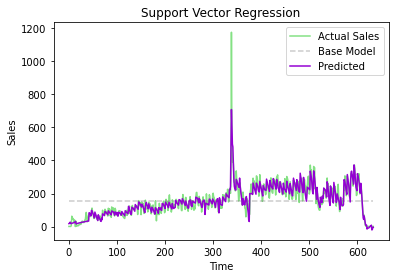

In [35]:
mlpr = MLPRegressor(hidden_layer_sizes=(100,30,10),
                    max_iter=100000,
                    activation='relu',
                    solver='lbfgs',
                    learning_rate='constant',
                    learning_rate_init=0.5,
                    tol=0.005)

pipe = make_pipeline(standardize, mlpr)

model = pipe.fit(X, y)

y_actual = y
y_base = [y.mean() for i in range(0, len(y))]
y_pred = model.predict(X)

fig, ax = plt.subplots()

ax.plot(y_actual, label='Actual Sales', color='limegreen', alpha=0.6)
ax.plot(y_base, label='Base Model', color='grey', alpha=0.4, linestyle='dashed')
ax.plot(y_pred, label='Predicted', color='darkviolet')

ax.set_title('Support Vector Regression')
ax.set_xlabel('Time')
ax.set_ylabel('Sales')

ax.legend(loc='upper right')

plt.show()

/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


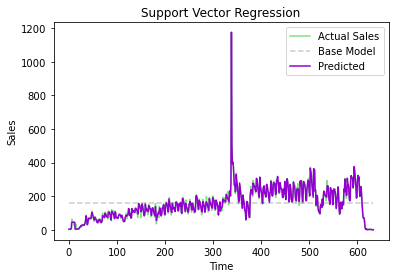

In [36]:
final_mlpr = MLPRegressor(hidden_layer_sizes=(100,30,10),
                          activation='relu',
                          solver='lbfgs',
                          tol=0.005,
                          learning_rate_init=0.3,
                          max_iter=100000)

pipe = make_pipeline(standardize, final_mlpr)

model = pipe.fit(X, y)

y_actual = y
y_base = [y.mean() for i in range(0, len(y))]
y_pred = model.predict(X)

fig, ax = plt.subplots()

ax.plot(y_actual, label='Actual Sales', color='limegreen', alpha=0.6)
ax.plot(y_base, label='Base Model', color='grey', alpha=0.4, linestyle='dashed')
ax.plot(y_pred, label='Predicted', color='darkviolet')

ax.set_title('Support Vector Regression')
ax.set_xlabel('Time')
ax.set_ylabel('Sales')

ax.legend(loc='upper right')

plt.show()

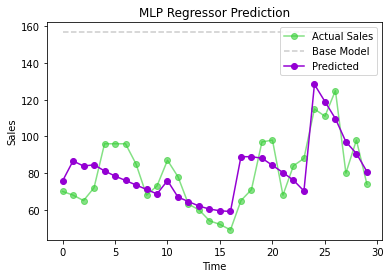

In [37]:
final_mlpr = MLPRegressor(hidden_layer_sizes=(100,30,10),
                          activation='relu',
                          solver='lbfgs',
                          tol=0.005,
                          learning_rate_init=0.3,
                          max_iter=100000)

pipe = make_pipeline(standardize, final_mlpr)

model = pipe.fit(X, y)

y_actual = y
y_base = [y.mean() for i in range(0, len(y))]
y_pred = model.predict(X)

fig, ax = plt.subplots()

ax.plot(y_actual[100:130], label='Actual Sales', color='limegreen', alpha=0.6, marker='o')
ax.plot(y_base[100:130], label='Base Model', color='grey', alpha=0.4, linestyle='dashed')
ax.plot(y_pred[100:130], label='Predicted', color='darkviolet', marker='o')

ax.set_title('MLP Regressor Prediction')
ax.set_xlabel('Time')
ax.set_ylabel('Sales')

ax.legend(loc='upper right')

plt.show()

## Support Vector Regression

In [38]:
from sklearn.svm import LinearSVR

In [39]:
X = model_df.loc[:, ['year', 'month', 'week_num_in_year', 'date']].to_numpy()
y = model_df.loc[:, 'count_order'].to_numpy()

### Hyperparameter Tuning

In [40]:
rmse_scorer = make_scorer(mean_squared_error, squared=False)

pipe = Pipeline([
        ('scale', StandardScaler()),
        ('svr', LinearSVR())])

param_grid = dict(svr__tol=[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5],
                  svr__max_iter=[10000],
                  svr__loss=['epsilon_insensitive', 'squared_epsilon_insensitive'],
                  svr__C=[1, 2, 3, 5, 7, 9, 11, 13])

grid = GridSearchCV(pipe, param_grid=param_grid, cv=TimeSeriesSplit(),
                    scoring=rmse_scorer, n_jobs=1, verbose=1)
grid.fit(X, y)

Fitting 5 folds for each of 160 candidates, totalling 800 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('svr', LinearSVR())]),
             n_jobs=1,
             param_grid={'svr__C': [1, 2, 3, 5, 7, 9, 11, 13],
                         'svr__loss': ['epsilon_insensitive',
                                       'squared_epsilon_insensitive'],
                         'svr__max_iter': [10000],
                         'svr__tol': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05,
                                      0.1, 0.5, 1, 5]},
             scoring=make_scorer(mean_squared_error, squared=False), verbose=1)

In [41]:
print(grid.best_score_)
print(grid.best_estimator_)

121.02388270041331
Pipeline(steps=[('scale', StandardScaler()),
                ('svr',
                 LinearSVR(C=9, loss='squared_epsilon_insensitive',
                           max_iter=10000, tol=1))])


### Default Parameter

In [42]:
svr = LinearSVR()

pipe = make_pipeline(standardize, svr)

_tscv(X, pipe)

[64.678025765739, 31.093601462004997, 134.49659261389937, 63.272349110136105, 124.57326033372469]
83.62276585710084


### Final Model

In [43]:
final_svr = LinearSVR(C=2, max_iter=2000, tol=0.05)

pipe = make_pipeline(standardize, final_svr)

_tscv(X, pipe)

[47.78396210142539, 30.42474573056662, 133.63242897359646, 61.93199939513662, 138.6167227136255]
82.47797178287013


In [44]:
final_svr = LinearSVR(C=2, max_iter=2000, tol=0.05)

pipe = make_pipeline(standardize, final_svr)

_tscv_eval(X, pipe)

[
    {
        "Median Absolute Error": 39.94932939784209,
        "Mean Absolute Error": 41.526298812712795,
        "Mean Squared Error": 2401.5940152506273,
        "Root Mean Squared Error": 49.00606100525349
    },
    {
        "Median Absolute Error": 21.786303022811012,
        "Mean Absolute Error": 23.662857640671778,
        "Mean Squared Error": 845.0274577363176,
        "Root Mean Squared Error": 29.06935599108308
    },
    {
        "Median Absolute Error": 42.19670130626366,
        "Mean Absolute Error": 65.76972004340324,
        "Mean Squared Error": 15976.73125905905,
        "Root Mean Squared Error": 126.3990951670899
    },
    {
        "Median Absolute Error": 42.18096255673973,
        "Mean Absolute Error": 50.742513297988914,
        "Mean Squared Error": 3940.753453050007,
        "Root Mean Squared Error": 62.77542077158868
    },
    {
        "Median Absolute Error": 67.69236392619763,
        "Mean Absolute Error": 100.42875216289737,
        "Mean Sq

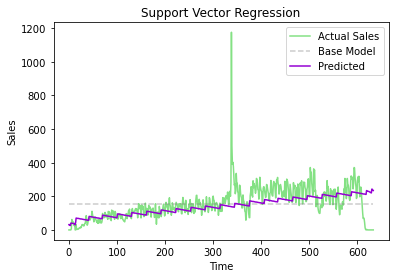

In [75]:
final_svr = LinearSVR(C=1,
                      max_iter=10000,
                      tol=0.5,
                      epsilon=0.5,
                      loss='squared_epsilon_insensitive',
                      dual=False)

pipe = make_pipeline(standardize, final_svr)

model = pipe.fit(X, y)

y_actual = y
y_base = [y.mean() for i in range(0, len(y))]
y_pred = model.predict(X)

fig, ax = plt.subplots()

ax.plot(y_actual, label='Actual Sales', color='limegreen', alpha=0.6)
ax.plot(y_base, label='Base Model', color='grey', alpha=0.4, linestyle='dashed')
ax.plot(y_pred, label='Predicted', color='darkviolet')

ax.set_title('Support Vector Regression')
ax.set_xlabel('Time')
ax.set_ylabel('Sales')

ax.legend(loc='upper right')

plt.show()

## SGD Regressor

In [46]:
from sklearn.linear_model import SGDRegressor

In [47]:
X = model_df.loc[:, ['year', 'month', 'week_num_in_year', 'date']].to_numpy()
y = model_df.loc[:, 'count_order'].to_numpy()

### Hyperparameter Tuning

In [48]:
rmse_scorer = make_scorer(mean_squared_error, squared=False)

pipe = Pipeline([
        ('scale', StandardScaler()),
        ('sgdr', SGDRegressor())])

param_grid = dict(sgdr__loss=['squared_loss', 'huber'],
                  sgdr__epsilon=[0.1,0.3,0.5,0.7,1],
                  sgdr__learning_rate=['constant', 'invscaling', 'adaptive'],
                  sgdr__eta0=[0.01,0.03,0.05,0.1,0.3,0.5,1,3,5,10],
                  sgdr__max_iter=[5000,10000],
                  sgdr__alpha=[0.0001,0.0005,0.001,0.003])

grid = GridSearchCV(pipe, param_grid=param_grid, cv=TimeSeriesSplit(),
                    scoring=rmse_scorer, n_jobs=1, verbose=1)
grid.fit(X, y)

Fitting 5 folds for each of 2400 candidates, totalling 12000 fits


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:1228: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:1228: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:1228: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:1228: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linea

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('sgdr', SGDRegressor())]),
             n_jobs=1,
             param_grid={'sgdr__alpha': [0.0001, 0.0005, 0.001, 0.003],
                         'sgdr__epsilon': [0.1, 0.3, 0.5, 0.7, 1],
                         'sgdr__eta0': [0.01, 0.03, 0.05, 0.1, 0.3, 0.5, 1, 3,
                                        5, 10],
                         'sgdr__learning_rate': ['constant', 'invscaling',
                                                 'adaptive'],
                         'sgdr__loss': ['squared_loss', 'huber'],
                         'sgdr__max_iter': [5000, 10000]},
             scoring=make_scorer(mean_squared_error, squared=False), verbose=1)

In [49]:
print(grid.best_score_)
print(grid.best_estimator_)

63006095615818.336
Pipeline(steps=[('scale', StandardScaler()),
                ('sgdr',
                 SGDRegressor(epsilon=0.7, eta0=10, learning_rate='constant',
                              max_iter=10000))])


### Default Parameter & Final Model

In [50]:
sgdr = SGDRegressor()

pipe = make_pipeline(standardize, sgdr)

_tscv(X, pipe)

[34.198318788754825, 36.16048112624085, 125.59522718648033, 70.84011698231592, 154.34213878336635]
84.22725657343166


In [51]:
sgdr = SGDRegressor()

pipe = make_pipeline(standardize, sgdr)

_tscv_eval(X, pipe)

[
    {
        "Median Absolute Error": 23.390674580621607,
        "Mean Absolute Error": 27.434588854599212,
        "Mean Squared Error": 1196.717756257169,
        "Root Mean Squared Error": 34.593608604150695
    },
    {
        "Median Absolute Error": 24.736001123668814,
        "Mean Absolute Error": 29.363206448248626,
        "Mean Squared Error": 1312.1223759912925,
        "Root Mean Squared Error": 36.223229784094244
    },
    {
        "Median Absolute Error": 46.59343554058768,
        "Mean Absolute Error": 67.09872498772725,
        "Mean Squared Error": 15789.020662681545,
        "Root Mean Squared Error": 125.65436985111798
    },
    {
        "Median Absolute Error": 44.90992096963234,
        "Mean Absolute Error": 55.00571013122027,
        "Mean Squared Error": 5013.2053717135095,
        "Root Mean Squared Error": 70.80399262551165
    },
    {
        "Median Absolute Error": 88.53344794415426,
        "Mean Absolute Error": 116.16490019667498,
        "Me

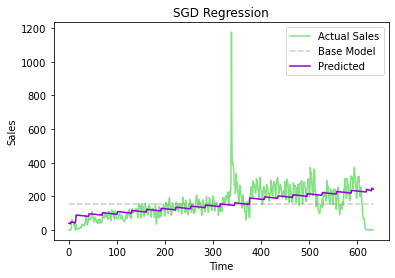

In [81]:
# SGDRegressor(epsilon=0.7, eta0=10, learning_rate='constant',
#                               max_iter=10000)

# sgdr = SGDRegressor(epsilon=0.7,
#                     eta0=0.1,
#                     learning_rate='constant',
#                     max_iter=10000
#                    )

sgdr = SGDRegressor()

pipe = make_pipeline(standardize, sgdr)

model = pipe.fit(X, y)

y_actual = y
y_base = [y.mean() for i in range(0, len(y))]
y_pred = model.predict(X)

fig, ax = plt.subplots()

ax.plot(y_actual, label='Actual Sales', color='limegreen', alpha=0.6)
ax.plot(y_base, label='Base Model', color='grey', alpha=0.4, linestyle='dashed')
ax.plot(y_pred, label='Predicted', color='darkviolet')

ax.set_title('SGD Regression')
ax.set_xlabel('Time')
ax.set_ylabel('Sales')

ax.legend(loc='upper right')

plt.show()

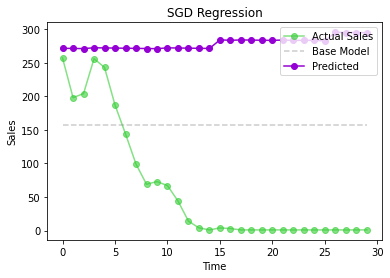

In [53]:
sgdr = SGDRegressor()

pipe = make_pipeline(standardize, sgdr)

model = pipe.fit(X[:len(X)-30], y[:len(y)-30])

y_actual = y[len(y)-30:]
y_base = [y.mean() for i in range(0, 30)]
y_pred = model.predict(X[len(X)-30:])

fig, ax = plt.subplots()

ax.plot(y_actual, label='Actual Sales', color='limegreen', alpha=0.6, marker='o')
ax.plot(y_base, label='Base Model', color='grey', alpha=0.4, linestyle='dashed')
ax.plot(y_pred, label='Predicted', color='darkviolet', marker='o')

ax.set_title('SGD Regression')
ax.set_xlabel('Time')
ax.set_ylabel('Sales')

ax.legend(loc='upper right')

plt.show()

## Random Forest Regression

In [54]:
from sklearn.ensemble import RandomForestRegressor

In [55]:
X = model_df.loc[:, ['year', 'month', 'week_num_in_year', 'date']].to_numpy()
y = model_df.loc[:, 'count_order'].to_numpy()

### Hyperparameter Tuning

In [56]:
rmse_scorer = make_scorer(mean_squared_error, squared=False)

pipe = Pipeline([
        ('scale', StandardScaler()),
        ('rfr', RandomForestRegressor())])

param_grid = dict(rfr__n_estimators=[100,150,200,250,300],
                  rfr__criterion=['mae'])

grid = GridSearchCV(pipe, param_grid=param_grid, cv=TimeSeriesSplit(),
                    scoring=rmse_scorer, n_jobs=1, verbose=1)
grid.fit(X, y)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('rfr', RandomForestRegressor())]),
             n_jobs=1,
             param_grid={'rfr__criterion': ['mae'],
                         'rfr__n_estimators': [100, 150, 200, 250, 300]},
             scoring=make_scorer(mean_squared_error, squared=False), verbose=1)

In [57]:
print(grid.best_score_)
print(grid.best_estimator_)

95.82687781170479
Pipeline(steps=[('scale', StandardScaler()),
                ('rfr',
                 RandomForestRegressor(criterion='mae', n_estimators=300))])


### Final Model

In [58]:
rfr = RandomForestRegressor()

pipe = make_pipeline(standardize, rfr)

_tscv_eval(X, pipe)

[
    {
        "Median Absolute Error": 41.33,
        "Mean Absolute Error": 44.612476190476194,
        "Mean Squared Error": 3188.0829457142854,
        "Root Mean Squared Error": 56.463111371180084
    },
    {
        "Median Absolute Error": 68.47,
        "Mean Absolute Error": 68.78704761904763,
        "Mean Squared Error": 6065.1678552380945,
        "Root Mean Squared Error": 77.87918756149229
    },
    {
        "Median Absolute Error": 139.24,
        "Mean Absolute Error": 139.38495238095237,
        "Mean Squared Error": 34524.140596190475,
        "Root Mean Squared Error": 185.80672914668745
    },
    {
        "Median Absolute Error": 48.18000000000001,
        "Mean Absolute Error": 50.98390476190476,
        "Mean Squared Error": 3848.6419457142856,
        "Root Mean Squared Error": 62.03742375142834
    },
    {
        "Median Absolute Error": 74.03,
        "Mean Absolute Error": 85.47390476190476,
        "Mean Squared Error": 10435.338262857143,
        "Ro

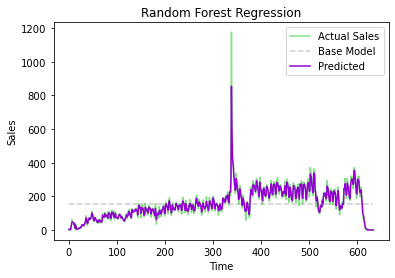

In [82]:
# rfr = RandomForestRegressor()

rfr = RandomForestRegressor(criterion='mae',
                            n_estimators=300
                           )

pipe = make_pipeline(standardize, rfr)

model = pipe.fit(X, y)

y_actual = y
y_base = [y.mean() for i in range(0, len(y))]
y_pred = model.predict(X)

fig, ax = plt.subplots()

ax.plot(y_actual, label='Actual Sales', color='limegreen', alpha=0.6)
ax.plot(y_base, label='Base Model', color='grey', alpha=0.4, linestyle='dashed')
ax.plot(y_pred, label='Predicted', color='darkviolet')

ax.set_title('Random Forest Regression')
ax.set_xlabel('Time')
ax.set_ylabel('Sales')

ax.legend(loc='upper right')

plt.show()